In [1]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.io.ascii
%matplotlib inline
import pandas as pd
import radvel

/home/dcrocker/anaconda3/lib/python3.10/site-packages/radvel/gp.py:32: ImportWarning: celerite not installed. GP kernals using celerite will not work. Try installing celerite using 'pip install celerite'
  warnings.warn("celerite not installed. GP kernals using celerite will not work. \


## Read in RV data for HD 17156 b

In [2]:
rv_data = astropy.io.ascii.read("rv_hd189733.txt")
rv_data

JD,Radial_Velocity,Radial_Velocity_Uncertainty
days,m / s,m / s
float64,float64,float64
2452832.881794,-13.964,1.542
2452898.800937,186.717,1.48
2453180.918877,153.226,1.609
2453240.898507,121.542,1.139
2453303.750382,-202.928,1.244
2453303.753576,-203.187,1.139
2453551.963519,-126.301,1.205
2453693.688738,15.243,1.228


## Plot the best-fit model

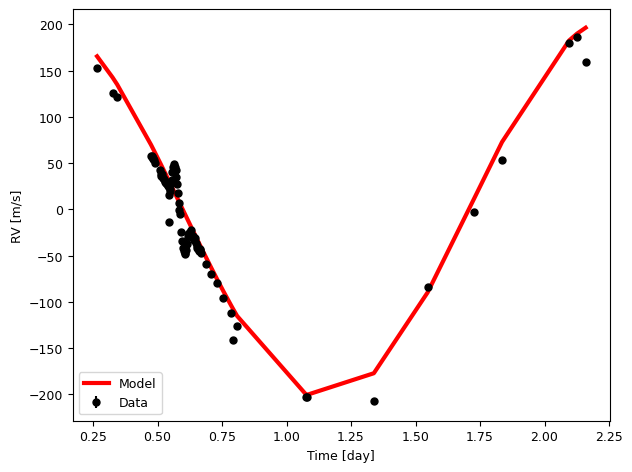

In [3]:
t = rv_data["JD"].data
orbital_solution = [2.2185752, 2452833.21794, 0, 136 / 360.0 * 2 * np.pi, 205]
rvs = radvel.kepler.rv_drive(t, orbital_solution, use_c_kepler_solver=False)

per = orbital_solution[0]

%matplotlib inline
# Fold data and plot model against data
ind = np.argsort(t % per)
plt.errorbar(rv_data["JD"] % per, rv_data["Radial_Velocity"], rv_data["Radial_Velocity_Uncertainty"], 
             color="black", ms=5, marker="o", ls="none", label="Data")
plt.plot((t % per)[ind], rvs[ind], "r-", label="Model", lw=3)
plt.legend()
plt.xlabel("Time [day]")
plt.ylabel("RV [m/s]")
plt.tight_layout()

## Read in transit data for HD 17156 b

## Fitting RV data for HD 17156 b

In [4]:
import scipy.signal as signal
x = rv_data["JD"]
y = rv_data["Radial_Velocity"]
e = rv_data["Radial_Velocity_Uncertainty"]


## Finding the periodicity in the data

In [5]:
nout = 1e5
f = np.linspace(0.01, 10.0, int(nout)) # frequency (1/day) at which power is calculated. 
#pgram = signal.lombscargle(x, y, f, normalize=True)
pgram = signal.lombscargle(x, y, f)

Text(0, 0.5, 'Power')

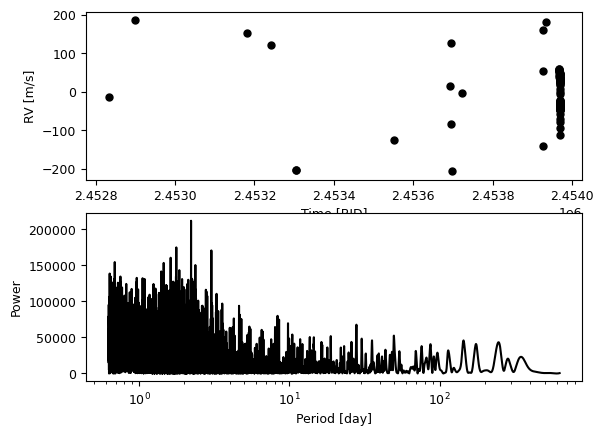

In [6]:
plt.subplot(2, 1, 1)
plt.errorbar(x, y , e, ms=5, marker="o", ls="none", color="black")
plt.xlabel("Time [BJD]")
plt.ylabel("RV [m/s]")
plt.subplot(2, 1, 2)
plt.plot(2 * np.pi / f, pgram, color="black")
plt.xscale("log")
plt.xlabel("Period [day]")
plt.ylabel("Power")

In [7]:
print("The period with the highest power is: ", 2 * np.pi / f[np.where(pgram == np.max(pgram))][0], " day")

The period with the highest power is:  2.218636200341774  day


## Now gather information for orbital solution from references, we are ready for MCMC, which gives uncertainties for best-fit parameters.



## Define a model function with five parameters: 

## period (day), time at periastron (MJD), eccentricity, argument of periastron (degree), RV amplitude (m/s)

In [8]:
# def calcModel(params, t_stamp=None):
#     per, t0, ecc, omega, rv_amp = params["per"], params["t0"], params["ecc"], params["omega"], params["K"]
#     rv = JW_lib.RadialVelocity([per, t0, ecc, omega, rv_amp])
#     return(rv.rv_drive(t_stamp))

def calcModel(params, t_stamp=None):
    per, t0, ecc, omega, rv_amp = params["per"], params["t0"], params["ecc"], params["omega"], params["K"]
    return(radvel.kepler.rv_drive(t_stamp, [per, t0, ecc, omega, rv_amp], use_c_kepler_solver=False))

## Define prior function 

In [9]:
def b_range(x, b):
    if x > b:
        return -np.inf
    else:
        return 0.

def a_b_range(x, a, b):
    if x < a:
        return -np.inf
    elif x > b:
        return -np.inf
    else:
        return 0.

def log_gaussian_prior(x, x0, std):
    return((-(x - x0)**2 / (2 * (std)**2)) / 2.3)




# define data and params that are fixed and variable
#planet_name = "HD 17156 b"
planet_name = "HD 17156 b"

if planet_name == "Teegarden b":
    log_priors = {}
    log_priors['per']           = lambda x: a_b_range(x, 4.8, 5.0)
    log_priors['t0']           = lambda x: a_b_range(x, 2458090.603207, 2458092.603207)
    log_priors['ecc']           = lambda x: a_b_range(x, 0., 0.95)
    log_priors['omega']       = lambda x: a_b_range(x, 0., 2*np.pi)
    log_priors['K']           = lambda x: a_b_range(x, 1., 5.)
    t_stamp      = rv_tg["col1"]
    data         = rv_tg["col2"]
    data_errors  = rv_tg["col3"]

    params = [4.910122, 2458, 0.222619, 82.339257 / 360 * 2 * np.pi,2.156248]
    params_keys = ["per", "t0", "ecc", "omega", "K"]
    params_fixed = []
    params_fixed_keys = []
elif planet_name == "HD 17156 b":
    log_priors = {}
    log_priors['per']           = lambda x: a_b_range(x, 1, 3)
    log_priors['t0']           = lambda x: a_b_range(x, 2452436.751157, 2454040.751157)
    log_priors['ecc']           = lambda x: a_b_range(x, 0., 0.95)
    log_priors['omega']       = lambda x: a_b_range(x, 0., 360.)
    log_priors['K']           = lambda x: a_b_range(x, 100., 500.)
    t_stamp      = rv_data["JD"]
    data         = rv_data["Radial_Velocity"]
    data_errors  = rv_data["Radial_Velocity_Uncertainty"]

    params = orbital_solution
    params_keys = ["per", "t0", "ecc", "omega", "K"]
    params_fixed = []
    params_fixed_keys = []
else:
    print(""" Give me either "HD 17156 b" or "Teegarden b" """)


## Define likelihood function 

In [10]:
def calc_log_prob(params, data, data_errors, params_keys=params_keys, params_fixed=params_fixed, \
                  params_fixed_keys=params_fixed_keys, t_stamp=t_stamp, plot_flag=False):
    # Make dictionary 
    params_dic = {}
    for i, key in enumerate(params_keys):
        params_dic[key]       = params[i]

    for i, key in enumerate(params_fixed_keys):
        params_dic[key]       = params_fixed[i]

    # Prior calculation of all input parameters
    log_prior = 0.

    for key in params_keys:
        if not(type(params_dic[key]) is list):
            log_prior += log_priors[key](params_dic[key])
        else:
            for val in params_dic[key]:
                log_prior += log_priors[key](val)

    # Return -inf if parameters fall outside prior distribution
    if (log_prior == -np.inf):
        return -np.inf
    
    # Calculate the log-likelihood
    log_likelihood = 0.

    # Calculate the forward model, this
    # returns the wavelengths in um and flux in W/m2

    rv_model = calcModel(params_dic, t_stamp=t_stamp)

    if plot_flag:
        plt.plot(t_stamp, rv_model, "k^-", alpha=0.5, label="model")
        plt.plot(t_stamp, data, "rx-", alpha=0.5, label="data")
        plt.xlabel("Time [BJD]")
        plt.ylabel("RV [m/s]")
        plt.legend()
        plt.show()

    # Just to make sure that a long chain does not die
    # unexpectedly:
    # Return -inf if forward model returns NaN values
    if np.sum(np.isnan(rv_model)) > 0:
        print("NaN spectrum encountered")
        return -np.inf

    # Calculate log-likelihood
    log_likelihood += -np.sum(((rv_model - data)/ \
                       data_errors)**2.)/2.

    if np.isnan(log_prior + log_likelihood):
        return -np.inf
    else:
        return log_prior + log_likelihood



## Test: calculate likelihood function

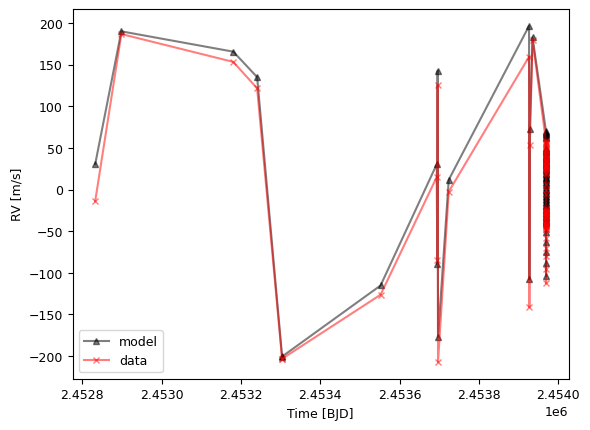

-15254.759777560725


In [11]:
print(calc_log_prob(params, data, data_errors, plot_flag=True))

## Now MCMC

In [12]:
import emcee

In [13]:
per = params[0]; e_per = 0.01
t0 = params[1]; e_t0 = 0.05
ecc = params[2]; e_ecc = 0.01
omega = params[3]; e_omega = 0.1
K = params[4]; e_K = 0.1


p_0 = params
e_p = [e_per, e_t0, e_ecc, e_omega, e_K]


ndim, nwalkers, nruns = len(p_0), 200, 1000
pos = [p_0 + e_p*np.random.randn(ndim) for i in range(nwalkers)]

import time as timer
start = timer.time()

from multiprocessing import Pool

# if pool works then use True, this option will use multi thread to increase computaional speed. Otherwise use False.
if True: 
    with Pool() as pool:
        print('start pool')
        # Initialize the sampler
        sampler = emcee.EnsembleSampler(nwalkers, ndim, calc_log_prob,
                                       args=(data, data_errors), pool=pool, threads=6)
        print('running sampler')
        sampler.run_mcmc(pos, 3000)


        #End timer
        end = timer.time()
        serial_time = end - start
        print("MCMC took {0:.1f} seconds".format(serial_time))
else:
        print('no sampler')
        # Initialize the sampler
        sampler = emcee.EnsembleSampler(nwalkers, ndim, calc_log_prob,
                                       args=(data, data_errors))
        sampler.run_mcmc(pos, 5000)


        #End timer
        end = timer.time()
        serial_time = end - start
        print("MCMC took {0:.1f} seconds".format(serial_time))    




start pool
running sampler
MCMC took 257.0 seconds


## Check MCMC result

In [14]:
samples = sampler.chain[:, 1000:, :].reshape((-1, ndim))[0:-1:10, :]


print("flat chain shape: {0}".format(samples.shape))


flat chain shape: (40000, 5)


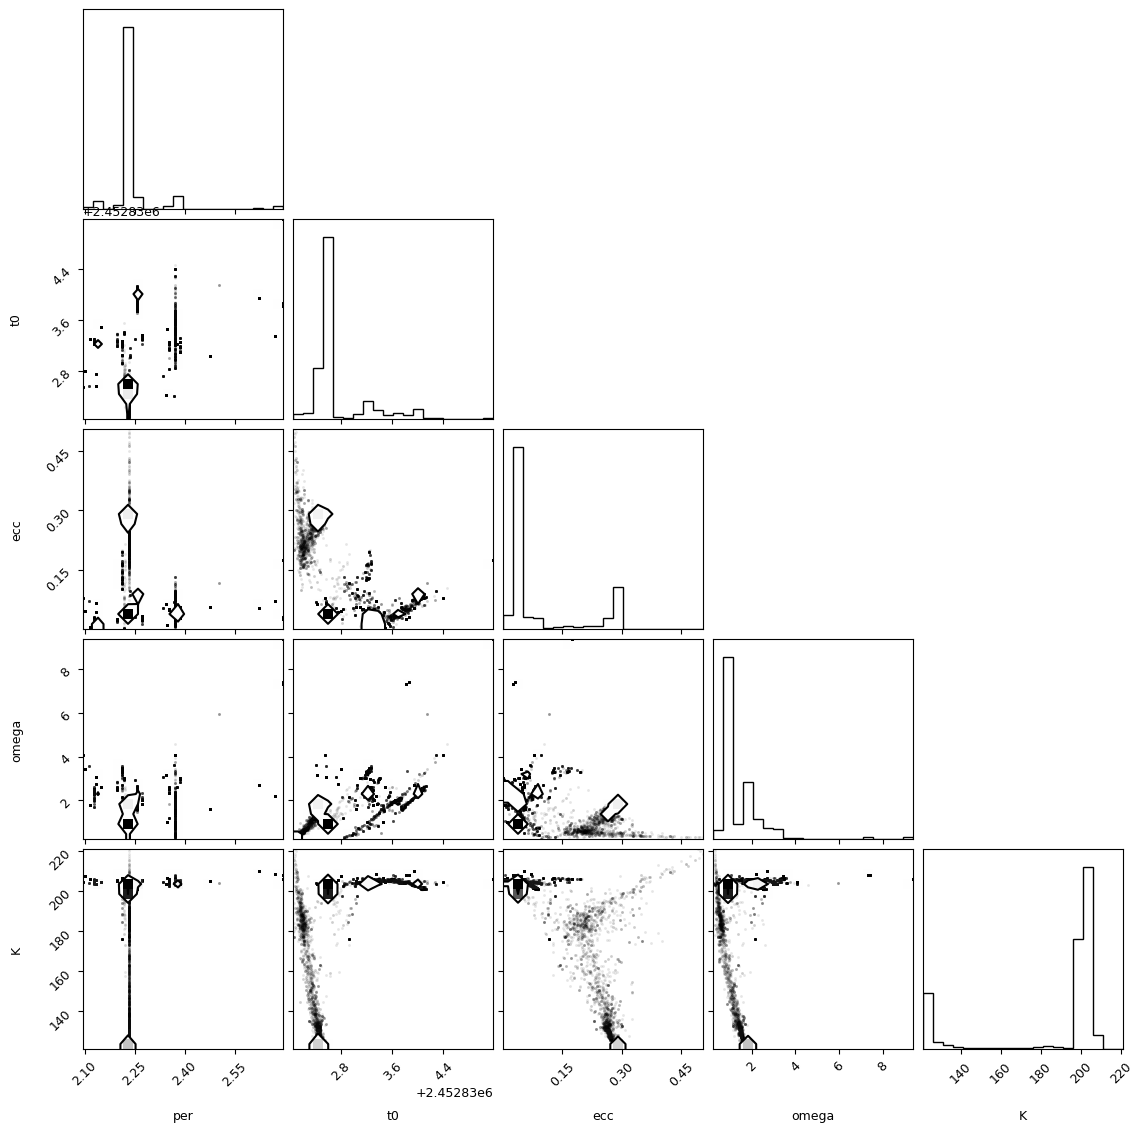

In [15]:
import corner
fig = corner.corner(samples, labels=params_keys, plot_contours=True)


## Plot models with data

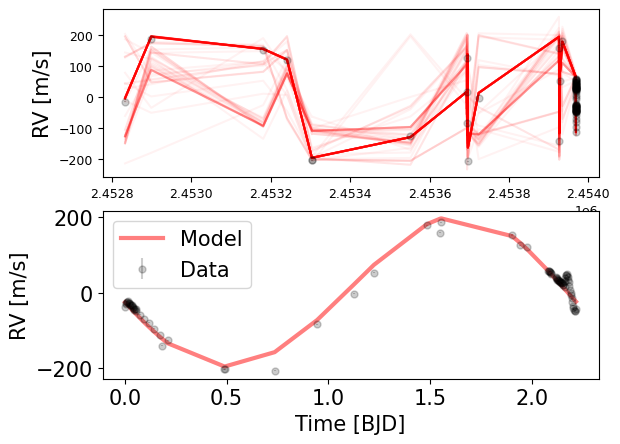

In [16]:
fig, ax = plt.subplots(2,1)

inds = np.random.randint(len(samples[:,0]), size=100)
for ind in inds:
    # Make dictionary 
    params_dic = {}
    for i, key in enumerate(params_keys):
        params_dic[key]       = samples[ind,:][i]        
    for i, key in enumerate(params_fixed_keys):
        params_dic[key]       = params_fixed[i]
    #print(params_dic["logg"])
    rv_model = calcModel(params_dic, t_stamp=t_stamp)
    ax[0].plot(t_stamp, rv_model, 'r', alpha=0.05,label='_nolegend_')
    
    
ax[0].errorbar(t_stamp, data, data_errors, ms=5, marker="o", alpha=0.2, ls="none", color="black", label="Data")
ax[0].plot(t_stamp, rv_model, "r", alpha=0.5, label="Model")


# Getting median values
values = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [16, 50, 84],
                                                axis=0)))
params = np.array(list(values))[:,0]
params_fixed = []
params_dic = {}
for i, key in enumerate(params_keys):
    params_dic[key]       = params[i]
for i, key in enumerate(params_fixed_keys):
    params_dic[key]       = params_fixed[i]


rv_model = calcModel(params_dic, t_stamp=t_stamp)
per = params_dic["per"]
ind1 = np.argsort(t_stamp % per)
ax[1].errorbar(t_stamp % per, data, data_errors, ms=5, marker="o", alpha=0.2, ls="none", color="black", label="Data")
ax[1].plot((t_stamp % per)[ind1], rv_model[ind1], "r", alpha=0.5,label='Model', lw=3)

ax[1].set_xlabel("Time [BJD]", fontsize=15)
ax[0].set_ylabel("RV [m/s]", fontsize=15)
ax[1].set_ylabel("RV [m/s]", fontsize=15)

plt.gca().tick_params(labelsize=15)
ax[1].legend(fontsize=15)
# plt.tight_layout()
# plt.savefig("model_data.png")

In [19]:
params_dic

{'per': 2.2186620052799295,
 't0': 2452832.6256723325,
 'ecc': 0.03745031005858924,
 'omega': 0.8720001289989279,
 'K': 200.9051242079653}

In [20]:
errk=np.percentile(samples, [16, 50, 84],axis=0)[2,4]-np.percentile(samples, [16, 50, 84],axis=0)[1,4]
print('K=',np.percentile(samples, [16, 50, 84],axis=0)[1,4],'+/-',errk)
errp=np.percentile(samples, [16, 50, 84],axis=0)[2,0]-np.percentile(samples, [16, 50, 84],axis=0)[1,0]
print('P=',np.percentile(samples, [16, 50, 84],axis=0)[1,0],'+/-',errp)

K= 200.9051242079653 +/- 2.889573867625387
P= 2.2186620052799295 +/- 0.013895856776023674


In [28]:
# P is a period from above
# errp is period uncertainty
# K is measured K
# errk is K uncertainty
P=np.percentile(samples, [16, 50, 84],axis=0)[1,0]
K=np.percentile(samples, [16, 50, 84],axis=0)[1,4]
G=6.67e-11
Mstar=0.84
def func(k,p):
    Mp=k/28.4329*Mstar**(2/3)*(p/365)**(1/3)
    return Mp
masses=[]

for j in range(50): #this can be increased or decreased as neede #initialize random number generator
    P_samp=np.random.normal(loc=P,scale=errp) #randomize P
    K_samp=np.random.normal(loc=K,scale=errk) #randomize K
    
    #repeat radius measuring process
    Mp=func(K_samp,P_samp) #func is a function (or some other code) that you used to find the mass of the planet. 
    masses.append(Mp) #append new radius measurement
    
sig_Mp=np.std(masses) #gets you the uncertainty for planet mass
Mp=np.mean(masses) #gets you the uncertainty for planet mass
print('Mp=',Mp,'+/-',sig_Mp,'Mjup')

Mp= 1.1477121953139102 +/- 0.014646518383500286 Mjup
